# Case Study 10 - Data Imputation

Allen Ansari, Chris Ballenger, Shantanu Godbole, Chad Madding

DS 7333 Quantifying the World

July 5, 2020

## Table of Contents


## Abstract  

Many real world datasets contain blanks, NAN, values that incorrect for various reasons. Training a model on the dataset that has missing values can impact the performance of the model. Deleting the records with missing values might result in throwing off some important information from the existing features, therefore there are many statistical methods that can be used to infer the missing values based on other values that are available in the dataset.  


## Introduction

We will be looking at the Boston Housing Dataset. The dataset has no missing values. Therefore we will establish a baseline and then delete the existing values to simulate the missing data. 

There are various types of missing data but in this Case study we will be looking at 2 types:

1. Missing Completely at Random: There is not particular pattern that is observed in the missing data. 

2. Missing not at Random: There can be a certain pattern that can be established behind the values that are missing. 



## Data

In [32]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [33]:
import pandas as pd

boston_df = pd.DataFrame(boston["data"],columns = boston["feature_names"])
boston_df["target"] = boston["target"]
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Data Exploration

Using pairwise grid, we want to learn what the data may be able to tell us before modeling and ensure we have a clean dataset.

* `RM` and `LSTAT` has a postive and negative correlation to price (target), respectively
* `ZN`, `CRIM`, `DIS`, and `NOX` has right skewness
* `ZN` and `B` both has high frequency of same values

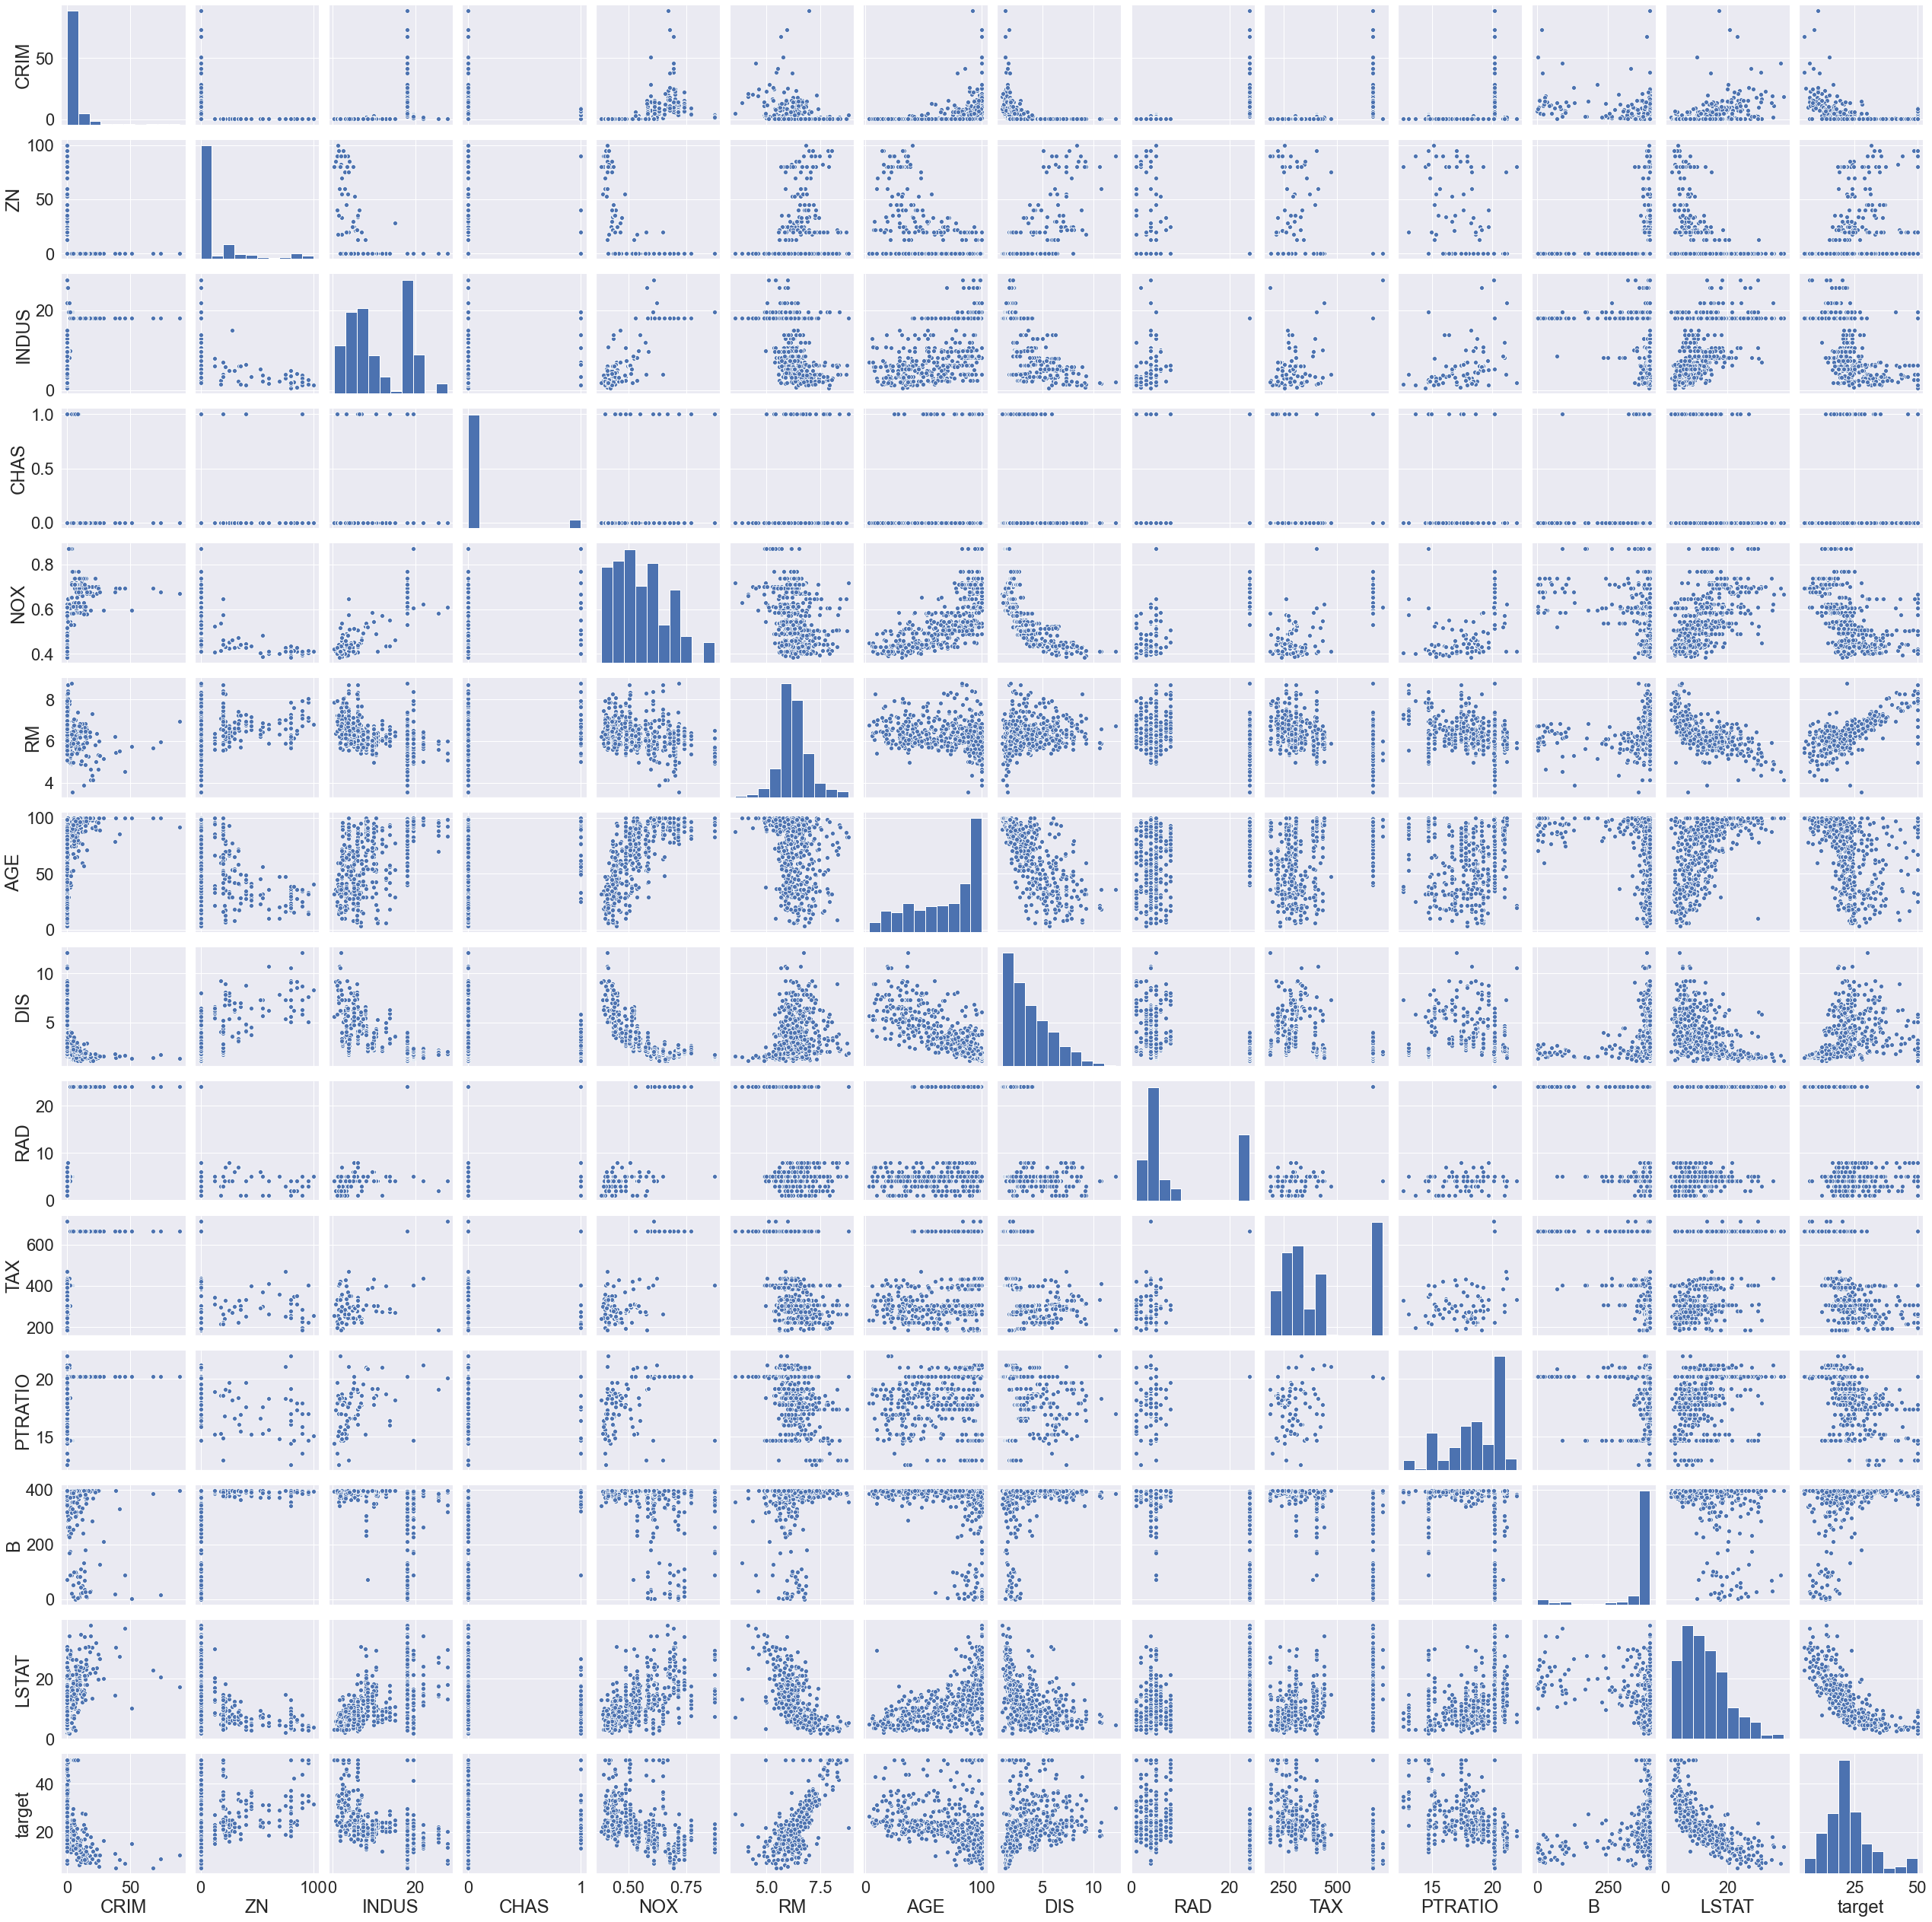

Figure 1: Boston Data Matrix


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2)
ax = sns.pairplot(boston_df)

plt.show()

print("Figure 1: Boston Data Matrix")

**Log Scale**

`CRIM`, `DIS`, and `NOX` all look better after a log transformation, but `ZN` still does not improve, most likely due to high freqncy of same value.  In the next section we will inspect `ZN`.

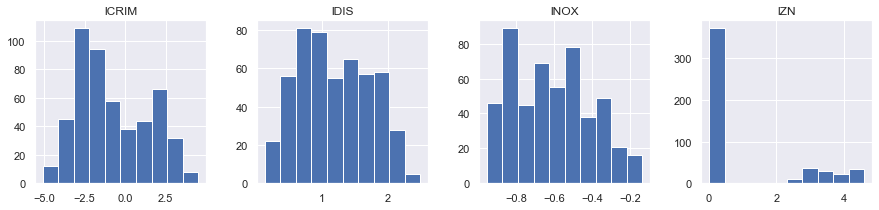

Figure 2: Histogram after Log Scale


In [90]:
import numpy as np
import matplotlib.pyplot as plt


boston_df_ = boston_df.copy()
boston_df_["lCRIM"] = np.log(boston_df_.CRIM)
boston_df_["lZN"] = np.log(boston_df_.ZN + 1)
boston_df_["lDIS"] = np.log(boston_df_.DIS)
boston_df_["lNOX"] = np.log(boston_df_.NOX)
boston_df_.drop(["CRIM","ZN","DIS","NOX"], axis=1, inplace=True)


sns.set(font_scale=1)
ax = boston_df_[["lCRIM","lZN","lDIS","lNOX"]].hist(
    layout=(1,4), 
    figsize=(15,3)
)


plt.show()
print("Figure 2: Histogram after Log Scale")

The following has extreme skewness with high percetage with the same values.
* ZN - Has a high frequency of same values
* B - Extrem Right Skewness

In [35]:
ZN = boston_df.ZN.value_counts()
display((ZN / sum(ZN)).head().reset_index())
print("Top 5 percentage of rows with same value for feature ZN")

,index,ZN
0,0.0,0.735178
1,20.0,0.041502
2,80.0,0.029644
3,12.5,0.019763
4,22.0,0.019763


Top 5 percentage of rows with same value for feature ZN


In [36]:
B = boston_df.B.value_counts().head(5)
display((B / sum(B)).head())
print("Top 5 percentage of rows with same value for feature B")

396.90    0.923664
395.24    0.022901
393.74    0.022901
393.23    0.015267
394.72    0.015267
Name: B, dtype: float64

Top 5 percentage of rows with same value for feature B


We will remove `ZN` & `B` from our dataset.  In addition `CRIM`, `DIM`, and `NOX` will be on the log scale.

In [37]:
boston_final = boston_df_.copy()

boston_final.drop(["target","lZN","B"], axis=1, inplace=True)
display(boston_final.dtypes)
print("Final Columns")

INDUS      float64
CHAS       float64
RM         float64
AGE        float64
RAD        float64
TAX        float64
PTRATIO    float64
LSTAT      float64
lCRIM      float64
lDIS       float64
lNOX       float64
dtype: object

Final Columns


## Modeling

The purpose of our research is to measure the Mean Square Error (MSE) when missing data is present.  In order to create a fair assessment, we will hold out 20% of the data for testing.  This data will not have any manipulation (imputation), otherthen log transformation. Our model with be a linear regression model.

**Steps we will take**
1. [Create](#1.-Create-a-train-&-test-dataset) a train & test dataset
2. [Fit](#2.-Fit-a-Baseline-Model) a Baseline Model
3. [Model](#3.-Model-Missing-Completely-at-Random) Missing Completely at Random
    1. Remove at random 10%, 20%, and 50% of its data for a single column
    2. Replace the missing values with athe mean
    2. Fit and predict on test
4. [Model](#4.-Model-Missing-Completely-Not-at-Random) Missing Completely Not at Random
    1. Remove by rule based, 10%, 20%, and 50%
    2. Fit and predict on test
    
**Measurments**
We will measure our imputation to a base line model using the following measurments
* R^2 - how much variance is explained by the model
* Mean Squared Error - Calculate how close our predicted values is to actual

### 1. Create a train & test dataset

In [38]:
from sklearn.model_selection import train_test_split

X = boston_final.values
y = boston["target"]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=76244)

print("Size of Training and Test")
print("Training:", len(train_X))
print("Test:", len(test_X))

Size of Training and Test
Training: 404
Test: 102


### 2. Fit a Baseline Model

In [39]:
from sklearn.linear_model import LinearRegression

ln_clf = LinearRegression()
ln_clf.fit(train_X,train_y)

baseline_measures = measures(ln_clf, test_X, test_y,"Baseline")

print("Our Baseline Model")
pd.DataFrame([baseline_measures])

Our Baseline Model


,model_type,r2,mse
0,Baseline,0.776,18.9596


### 3. Model Missing Completely at Random

In order to measure the impact of missing values, our test will include imputation at random for 10%, 20%, and 50% of the data for each column.  We will repeat our test 500 times and report on the average R^2 and MSE for each column and imputation percentage.  By using 500 iterations we will eliminate to possibility of a random imputation to report missleading results.

Our imputation will replace missing values with a new mean value for each column based on remaining values.  The below function prints out how imputation impacts a new mean value.

In [40]:
#### Imputation using Mean 

In [41]:
import random

#Randomly select a column
def replaceAtRandom(impute_values, pct, verbose = False):
    if verbose: print("Total Rows", len(impute_values))
    if verbose: print("Original Mean", round(np.mean(impute_values),2))

    idx = np.random.choice(range(len(impute_values)), int(len(impute_values)*.1))
    if verbose: print("Total Rows to impute at {0}%:".format(pct*100), len(idx))
    
    #Set values to NAN
    impute_values[idx] = np.NaN

    #Replace Value with a mean, excluding NAN
    impute_values[idx] = np.nanmean(impute_values)
    if verbose: print("Impute data with following mean", round(np.nanmean(impute_values),2))
    return impute_values

tmp = replaceAtRandom(train_X[:,0],0.20,verbose=True)

Total Rows 404
Original Mean 11.14
Total Rows to impute at 20.0%: 40
Impute data with following mean 11.12


In [42]:
import itertools
from tqdm import tqdm

columns = boston_final.columns
col_idx = list(range(0, len(columns)))
impute_percentages = [0.1, 0.2, 0.5]
iterations = [1] * 500

parameters = list(itertools.product(col_idx, impute_percentages, iterations))

results = []
# for i, col in enumerate(boston_final.columns):
#     for impute in impute_percentages:
#         for s in range(500):
for param in tqdm(parameters):
    i = param[0]
    impute = param[1]
    col = columns[i]
    
    train_X_impute = train_X.copy()
    impute_values = replaceAtRandom(train_X_impute[:,i],impute)
    train_X_impute[:,i] = impute_values

    ln_clf = LinearRegression()
    ln_clf.fit(train_X_impute,train_y)
    results.append(measures(ln_clf, test_X, test_y,"{0} - {1}".format(col, impute)))

missing_at_random = pd.DataFrame(results)
missing_at_random.to_csv("data/missing_at_random.csv",index=True)
    

100%|██████████| 16500/16500 [00:19<00:00, 845.02it/s]


In [43]:
import pandas as pd

missing_at_random = pd.read_csv("data/missing_at_random.csv", index_col=0)

# missing_at_random.groupby(["model_type"]).mean()

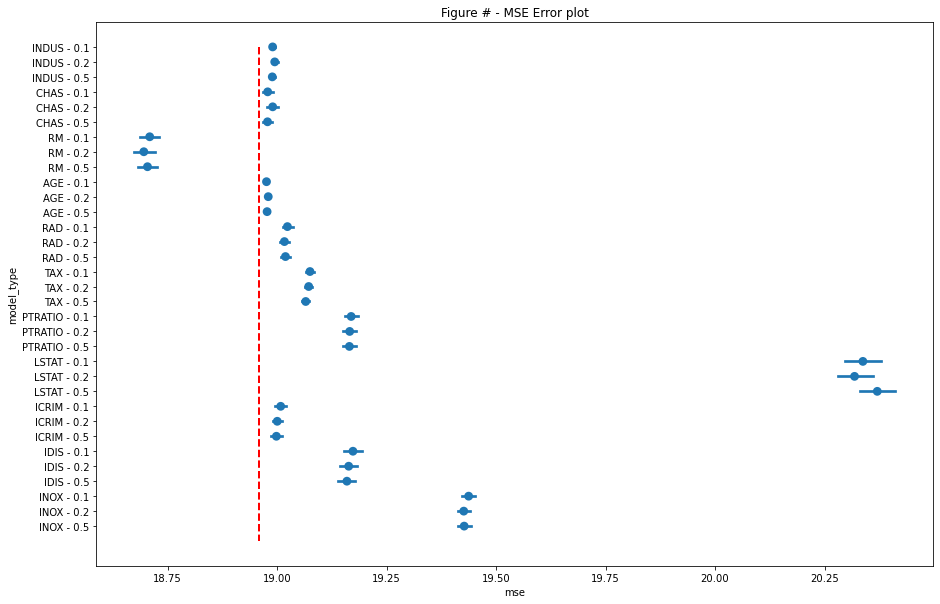

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_test = len(missing_at_random.model_type.unique())

fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="mse", y="model_type", data=missing_at_random, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["mse"], baseline_measures["mse"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - MSE Error plot")
plt.show()

The figure above shows how imputation can impact the MSE.  The dotted red line is the base line model. `LSTAT` had the biggest impact from the model and largest variance in error. Through our original EDA, we found `LSTAT` has a high negative correlation to price (`target`).  Only a handful of our columns were rarely impacted by our model and most were negatived impacted. Imputing `RM` at random did improved our model.  `RM` does have a postive correlation to price.

R^2 saw similar results as MSE.  `LSTAT` variance was impacted the hardest and `RM` variance was improved.

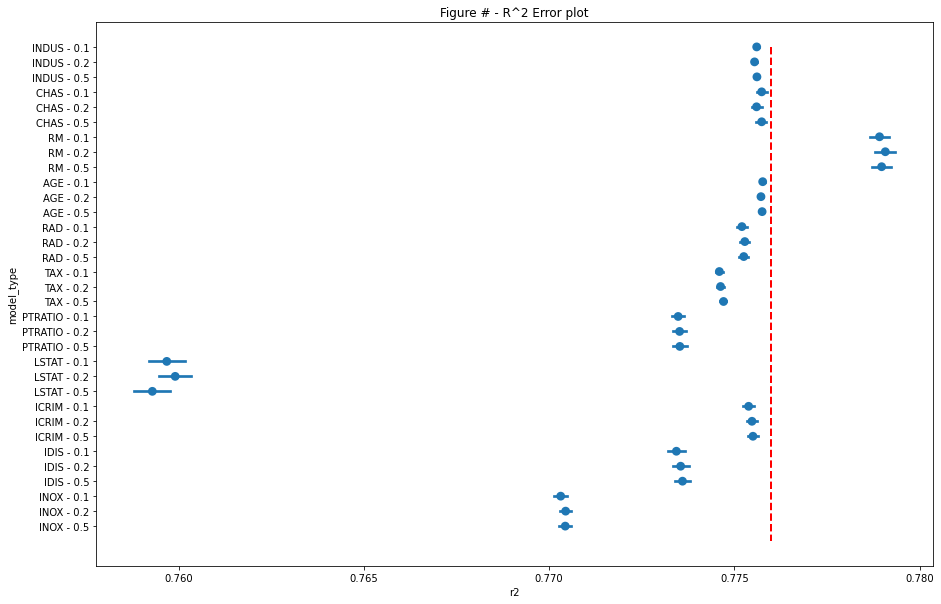

In [45]:
fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="r2", y="model_type", data=missing_at_random, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["r2"], baseline_measures["r2"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - R^2 Error plot")
plt.show()

Above figure shows the R^2 results when imputing each column by 10, 20, or 50%.  The dotted red line is the original base-line score.

In [ ]:
#### Random Imputation using KNN

In [58]:
#Randomly select a column


def replaceAtRandom_knn(index,data_array, pct, verbose = False):
    
    impute_values = data_array[:,index]
    
    if verbose: print("Total Rows", len(impute_values))
    if verbose: print("Original Mean", round(np.mean(impute_values),2))

    idx = np.random.choice(range(len(impute_values)), int(len(impute_values)*.1))
    if verbose: print("Total Rows to impute at {0}%:".format(pct*100), len(idx))
    
    #Set values to NAN
    
    data_array[idx,index] = np.NaN

    #Replace Value with a mean, excluding NAN
    
    data_array = imputer.fit_transform(data_array)
    
#     impute_values[idx] = np.nanmean(impute_values)
#     if verbose: print("Impute data with following mean", round(np.nanmean(impute_values),2))
    
    return data_array



In [51]:
tmp_array = replaceAtRandom_knn(1,train_X.copy(),0.20,verbose=True)

Total Rows 404
Original Mean 0.06
Total Rows to impute at 20.0%: 40


In [52]:
tmp_array

array([[18.1       ,  0.        ,  6.223     , ...,  2.88293865,
         0.32649405, -0.39898614],
       [ 4.49      ,  0.        ,  6.63      , ..., -2.85858244,
         1.49013622, -0.80073239],
       [18.1       ,  0.        ,  6.081     , ...,  1.91709466,
         0.99971234, -0.33827386],
       ...,
       [10.01      ,  0.        ,  5.872     , ..., -2.03576921,
         0.90724999, -0.60330648],
       [10.81      ,  0.        ,  6.065     , ..., -2.38988742,
         1.66530772, -0.88430769],
       [11.12188011,  0.        ,  6.059     , ..., -3.40943119,
         1.57115436, -0.66358838]])

In [59]:
# columns = boston_final.columns
# col_idx = list(range(0, len(columns)))
# impute_percentages = [0.1, 0.2, 0.5]
# iterations = [1] * 500

parameters = list(itertools.product(col_idx, impute_percentages, iterations))

results_random_knn = []
# for i, col in enumerate(boston_final.columns):
#     for impute in impute_percentages:
#         for s in range(500):
for param in tqdm(parameters):
    i = param[0]
    impute = param[1]
    col = columns[i]
    
    train_X_impute = train_X.copy()
    train_X_impute = replaceAtRandom_knn(i,train_X_impute,impute)

    ln_clf = LinearRegression()
    ln_clf.fit(train_X_impute,train_y)
    results_random_knn.append(measures(ln_clf, test_X, test_y,"{0} - {1}".format(col, impute)))



100%|██████████| 16500/16500 [00:48<00:00, 342.42it/s]


In [60]:
missing_at_random_knn = pd.DataFrame(results_random_knn)
missing_at_random_knn.to_csv("data/missing_at_random_knn.csv",index=True)

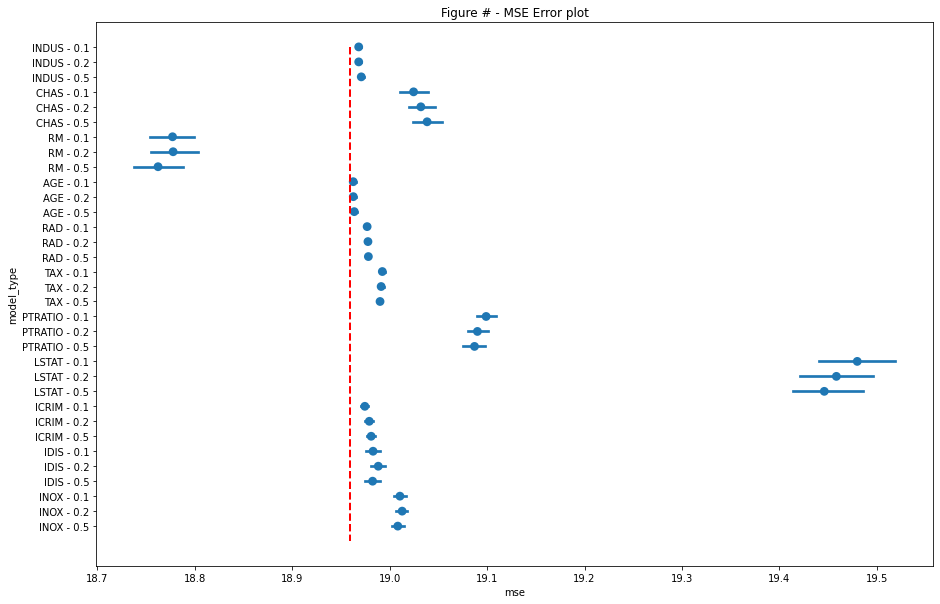

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_test = len(missing_at_random_knn.model_type.unique())

fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="mse", y="model_type", data=missing_at_random_knn, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["mse"], baseline_measures["mse"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - MSE Error plot")
plt.show()

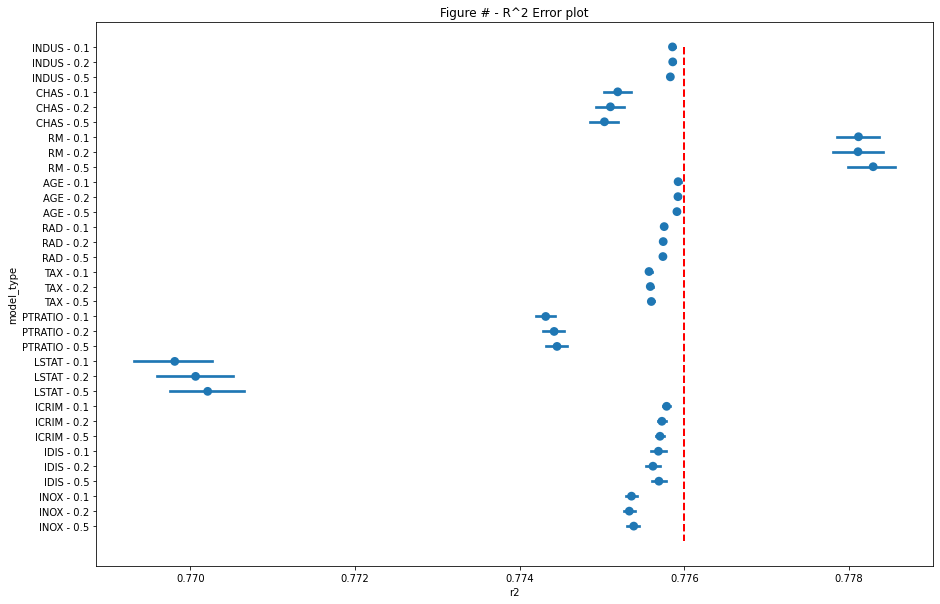

In [63]:
fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="r2", y="model_type", data=missing_at_random_knn, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["r2"], baseline_measures["r2"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - R^2 Error plot")
plt.show()

### 4. Model Missing Completely Not at Random

For imputing not at random, we will use `AGE` as our not random value.  Our goal is to observe what happens when you specifically remove values associated to an age range, for example 50 - 59 and replace with an adjusted mean (excludes `NaN` after removal of value).

We will impute each column to learn how they are impacted through our rule based approach.

In [17]:
import math

def roundDown(x):
    return int(math.floor(x / 10.0)) * 10


age_group = pd.DataFrame(train_X).iloc[:,3].apply(roundDown)

ct = age_group.value_counts()
pct = ct / sum(ct)
display( pct.reset_index().sort_values(by=["index"]).rename(columns={"index":"Age Group",3:"Pct"}) )

print("Impute 10% (80s AGE):", round(pct[80], 4))
print("Impute 20% (50s & 80s AGE):", round(pct[50] + pct[80], 4))
print("Impute 50% (10s, 50s 80s, & 90s AGE):", round(pct[10] + pct[50] + pct[80] + pct[90], 4))

,Age Group,Pct
10,0,0.024752
9,10,0.042079
8,20,0.054455
3,30,0.094059
5,40,0.074257
7,50,0.064356
6,60,0.071782
2,70,0.101485
1,80,0.131188
0,90,0.257426


Impute 10% (80s AGE): 0.1312
Impute 20% (50s & 80s AGE): 0.1955
Impute 50% (10s, 50s 80s, & 90s AGE): 0.495


Therefore, we will proceed removing data for the records corrosponging to the 'Age' column for each feature one at a time and replace it using KNN - Impute from sklearn.(sklearn.impute.KNNImputer)

Above - in the completly random imputation, we considered the column mean (of the existing) values and filled the missing values with the mean. In this section we will only consider the nearest 'n' number of records, and use the values for calculating the mean and the calculated mean will replace the missing value. 

In [78]:
#Randomly select a column

def replaceAtNotRandom_mean(impute_values, ages = [], verbose = False):
    
    if verbose: print("Total Rows", len(impute_values))
    if verbose: print("Original Mean", round(np.mean(impute_values),2))

#     idx = np.random.choice(range(len(impute_values)), int(len(impute_values)*.1))
    
#     if verbose: print("Total Rows to impute at {0}%:".format(pct*100), len(idx))
    
    #Set values to NAN
    impute_values[age_group.isin(ages)] = np.NaN

    #Replace Value with a mean, excluding NAN
    impute_values[age_group.isin(ages)] = np.nanmean(impute_values)
    if verbose: print("Impute data with following mean", round(np.nanmean(impute_values),2))
    return impute_values



In [79]:
tmp = replaceAtNotRandom_mean(train_X[:,0],[80],verbose=True)

Total Rows 404
Original Mean 10.89
Impute data with following mean 10.89


In [84]:
columns = boston_final.columns
col_idx = list(range(0, len(columns)))
impute_ages = [[80],[50,80],[10,50,80,90]]
iterations = [1] #* 500

parameters = list(itertools.product(col_idx, impute_ages, iterations))

results_nar_mean = []
# for i, col in enumerate(boston_final.columns):
#     for impute in impute_percentages:
#         for s in range(500):
for param in tqdm(parameters):
    i = param[0]
    impute = param[1]
    col = columns[i]
    
    train_X_impute = train_X.copy()
    impute_values = replaceAtNotRandom_mean(train_X_impute[:,i],ages)
    train_X_impute[:,i] = impute_values

    ln_clf = LinearRegression()
    ln_clf.fit(train_X_impute,train_y)
    results_nar_mean.append(measures(ln_clf, test_X, test_y,"{0} - {1}".format(col, impute)))

missing_not_at_random_mean = pd.DataFrame(results_nar_mean)
missing_not_at_random_mean.to_csv("data/missing_not_at_random_mean.csv",index=True)
    

100%|██████████| 33/33 [00:00<00:00, 517.35it/s]


In [86]:
missing_not_at_random_mean.shape

(33, 3)

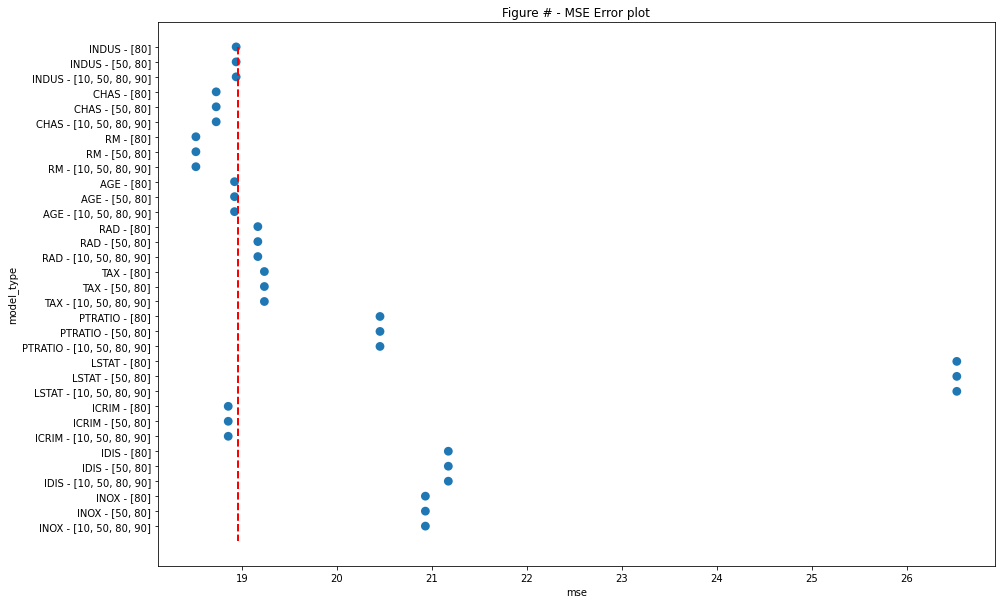

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_test = len(missing_not_at_random_mean.model_type.unique())

fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="mse", y="model_type", data = missing_not_at_random_mean, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["mse"], baseline_measures["mse"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - MSE Error plot")
plt.show()

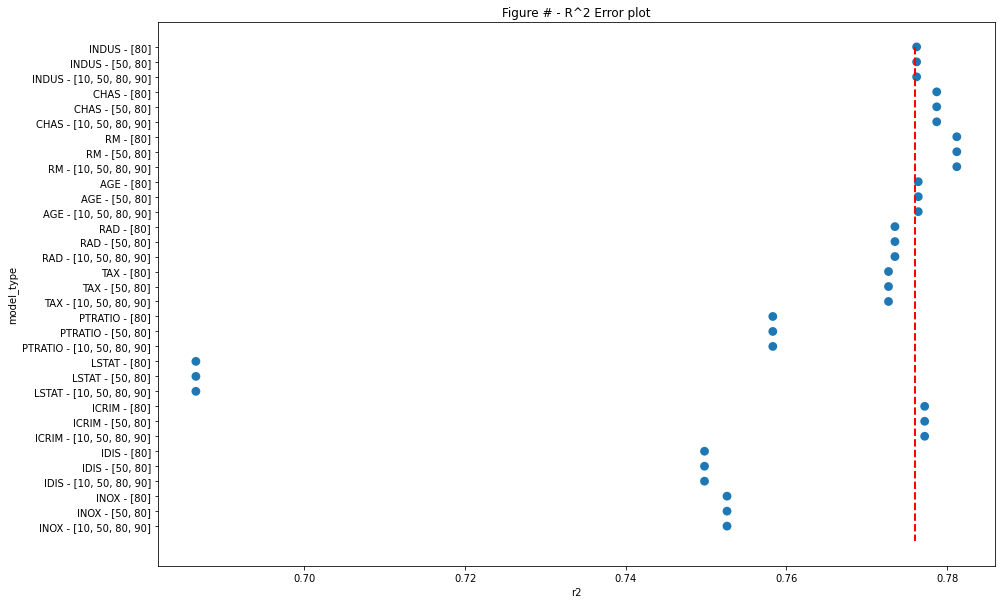

In [83]:
fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="r2", y="model_type", data = missing_not_at_random_mean, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["r2"], baseline_measures["r2"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - R^2 Error plot")
plt.show()

In [18]:
#Missing Not at Random
def replaceAtNotRandom(index,data_array, ages = [], verbose = False):
    
    impute_values = data_array[:,index]
    
    if verbose: print("Total Rows", len(impute_values))
    if verbose: print("Original Mean", round(np.mean(impute_values),2))

    if verbose: print("Total Rows to impute at {0}%:".format(pct*100), len(idx))
    
    #Set values to NAN
    data_array[:,index][age_group.isin(ages)] = np.NaN
    
    # Use KNN to impute the missing values. (sklearn - kNN Imputer)
    data_array = imputer.fit_transform(data_array)
    
    return data_array

In [19]:
import itertools
from tqdm import tqdm

In [20]:
columns = boston_final.columns
col_idx = list(range(0, len(columns)))
impute_ages = [[80],[50,80],[10,50,80,90]]
iterations = [1] 

parameters = list(itertools.product(col_idx, impute_ages, iterations))

results_nar = []
# for i, col in enumerate(boston_final.columns):
#     for impute in impute_percentages:
#         for s in range(500):


In [21]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)

In [26]:
for param in tqdm(parameters):
    
    i = param[0]
    ages = param[1]
    col = columns[i]
    
#     train_X_impute = train_X.copy()
#     impute_values = replaceAtRandom(train_X_impute[:,i],impute)
#     train_X_impute[:,i] = impute_values

    train_X_impute = replaceAtNotRandom(i,train_X.copy(),ages,verbose=False)

    ln_clf = LinearRegression()
    ln_clf.fit(train_X_impute,train_y)
    
    if ages == [80]:
        pct_imp = 0.10
    elif ages == [50,80]:
        pct_imp = 0.20
    elif ages == [10,50,80,90]:
        pct_imp = 0.50
        
    
    results_nar.append(measures(ln_clf, test_X, test_y,"{0} - {1}".format(col, pct_imp)))

missing_not_at_random = pd.DataFrame(results_nar)
missing_not_at_random.to_csv("data/missing_not_at_random.csv",index=True)

100%|██████████| 33/33 [00:00<00:00, 282.11it/s]


In [29]:
import pandas as pd

missing_not_at_random = pd.read_csv("data/missing_not_at_random.csv", index_col=0)


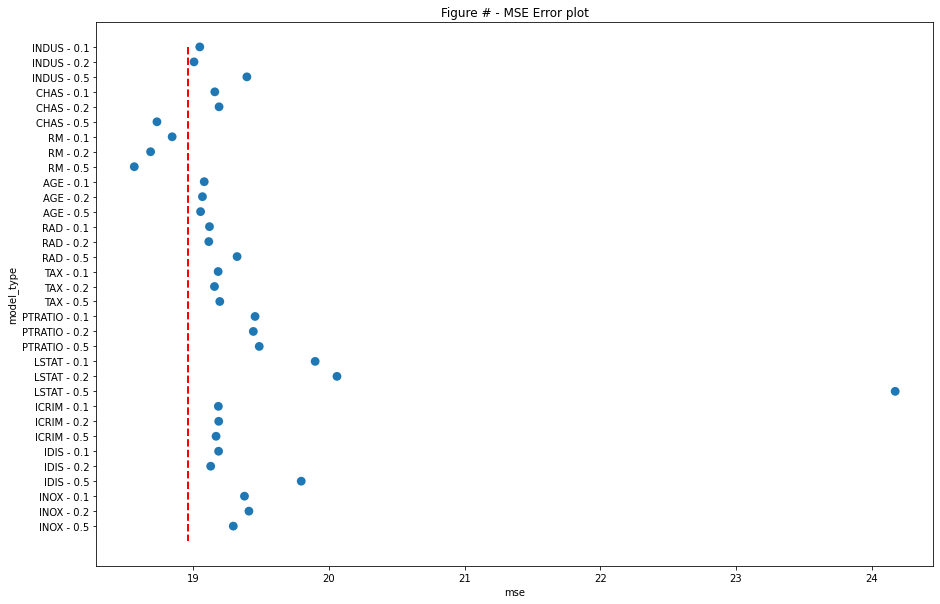

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_test_nar = len(missing_not_at_random.model_type.unique())

fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="mse", y="model_type", data = missing_not_at_random, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["mse"], baseline_measures["mse"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - MSE Error plot")
plt.show()

We can see that the `mse` stayed between 18 and 20, even when 50 % of data was missing in most of the cases, apart from `LSTAT`. Red line being the baseline `mse` for the model with no missing values. The model performed better - error wise for all the imputed values for the feature `RM`

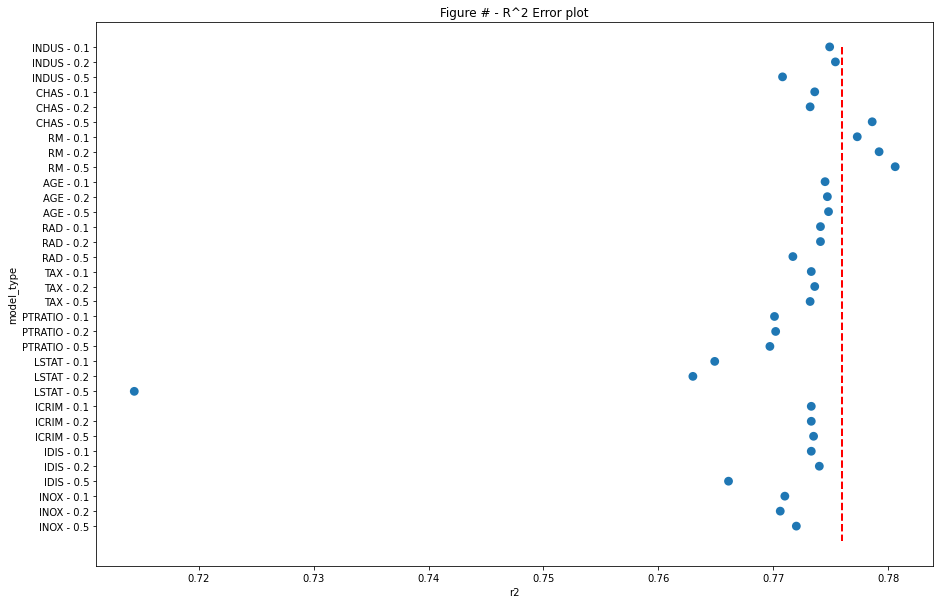

In [31]:
fig, ax = plt.subplots(figsize=(15,10))

sns.pointplot(x="r2", y="model_type", data=missing_not_at_random, join=False, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.plot([baseline_measures["r2"], baseline_measures["r2"]], [0, unique_test], "r--", linewidth=2)

plt.title("Figure # - R^2 Error plot")
plt.show()

## Appendix

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, log_loss


def measures(clf, test_X, test_y, model_type=""):
    y_hat = clf.predict(test_X)
    return {
        "model_type":model_type,
        "r2":round(r2_score(test_y, y_hat),4),
        "mse":round(mean_squared_error(test_y, y_hat),4),
#         "log_loss":round(log_loss(test_y,y_hat),4)
    }